In [1]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Game을 실행하는 start 함수 : 사용자가 직접 게임을 한다면, 초기 카드와 포지션에 대한 입력, 각 판당 결과와 승률 출력
각 입력 시 입력 받은 값의 노출과 게임 진행 상황(total)들은 이 함수 안에서 출력 (실제 강화 학습에서는 각 게임당 결과나 진행 사항을 출력할 필요없음)

Game을 진행하는 play 함수 : 실행 시에나 학습 시 직접 게임이 돌아가는 건 play로 구현. 나중에 강화 학습에서 agent가 될 부분. start를 실행하여 입력 받은 포지션에 따라서 play 함수를 호출하여 hit을 입력 받을 시에 사용자의 게임을 진행하고, stick을 입력 받을 시에 딜러의 게임을 자동으로 진행하여 게임 결과를 도출

* play를 시작하면 player와 dealer의 초기 카드 초기화

강화 학습 사용 시 class를 생성하여 학습 횟수를 입력 받을 때, 그 횟수만큼 학습을 진행하고 강화된 전략을 반영할 수 있어야 함
user가 사용할 때랑 학습을 할 때의 전략을 구분?? 

Game을 play할 때 card를 draw하는 함수, 각 진행 사항마다 total 값 출력, 한 판이 끝날 때 마다 게임 결과와 승무패를 반영하여 저장,


1. Implementation of Easy21

step 함수 : state(dealer's first card 1-10 and the player's sum 1-21) s와 action(hit or stick) a을 입력 받고 다음 state s'와 reward를 return (returns a sample of the next state s' which may be terminal if the game is finished) 
; 이 함수를 model-free RL의 environment로 사용할 것임. (there's no transition matrix for MDP)

* dealer의 전략은 환경의 일부로 다루어야 함. 즉, stick에 대한 action을 입력 받게 되면, dealer가 게임을 시작하고 final reward와 terminal state를 return




In [2]:
class State(object):
    def __init__(self):
        self.count = {'state': 0, 'hit': 0, 'stick': 0}
        self.action_value = {'hit':0, 'stick':0} # state value는 사용하지 않아도 되나? 사용할 경우 self.state_value 추가


state를 class로 관리하는데, 기본적으로 state는 tuple로 (dealer_card, player_total)의 형태로 구분한다.

state 안에 또 class를 두어 각 state의 visit 횟수, 각 state에서 action(hit or stick)을 선택한 횟수, state value, action value를 관리한다.

In [3]:
def step(state, action):
    
    """
    Args:
        state (tuple) : represent dealer_card and player_total in form of tuple (dealer_card, player_total)
                       state - dealer's first card 1-10 and the player's sum 1-21
        acntion (str) : 'hit' or 'stick'
    
    returns:
        state (tuple) : next state determined by input action. It could be terminal
        reward (int) : player's win +1, tie 0, lose -1
    """
    
    
    if action == 'hit':
        card = _draw_card()
        
        # update player's total 
        if card[1] == 'BLACK':
            next_state = (state[0], state[1] + card[0])
        elif card[1] == 'RED':
            next_state = (state[0], state[1] - card[0])
        
        # calculate reward
        if next_state[1] > 21 or next_state[1] < 1:
            reward = -1
        else:
            reward = 0
            
    elif action == 'stick':
        # dealer's play
        while True:
            card = _draw_card()
            if card[1] == 'BLACK':
                next_state = (state[0] + card[0], state[1])
            elif card[1] == 'RED':
                next_state = (state[0] - card[0], state[1])
            
            if next_state[0] >= 17 or next_state[0] < 1:
                break
            else:
                continue

        # calculate reward 
        if next_state[0] > 21 or next_state[0] < 1:
            reward = 1
        elif next_state[0] < next_state[1]:
            reward = 1
        elif next_state[0] > next_state[1]:
            reward = -1
        elif next_state[0] == next_state[0]:
            reward = 0

    return next_state, reward

In [4]:
def _draw_card():
    rand_number = random.randrange(1,11)
    color_number = random.randrange(1,4)
    
    if color_number == 1:
        color = 'RED'
    else:
        color = 'BLACK'
    
    return (rand_number, color)

In [5]:
def epsilon_greedy_policy(state):
    # N_0 is constant. Feel free to choose an alternative value for N0, if it helps producing better results.
    N_constant = 100
    
    random_action = random.random()
    epsilon = N_constant / (N_constant + state_dict[state].count['state'])
    if state_dict[state].action_value['hit'] > state_dict[state].action_value['stick']:
        hit_prob = (epsilon / 2) + 1 - epsilon
        #stick_prob = 1 - hit_prob
    else:
        hit_prob = (epsilon / 2)
    
    if random_action < hit_prob:
        action = 'hit'
    else:
        action = 'stick'
    
    return action

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

In [6]:
state_dict = {} # initialization 초기화

for dealer_card in range(1, 11):
    for player_total in range(1, 22):
        state_dict[(dealer_card, player_total)] = State()


In [7]:
number_of_learning = 1000 # 학습 횟수
 
for num in range(0, number_of_learning):
    initial_state = (random.randrange(1,11), random.randrange(1,22))
    initial_action = epsilon_greedy_policy(initial_state)
    cur_state = initial_state
    cur_action = initial_action
    state_dict[cur_state].count['state'] += 1
    state_dict[cur_state].count[cur_action] += 1
    
    # terminal state까지 반복
    while True:  
        (next_state, reward) = step(cur_state, cur_action)
        if cur_action == 'stick' or reward == -1 : # terminal state
            break
        else:
            cur_state = next_state
            cur_action = epsilon_greedy_policy(next_state)
            state_dict[cur_state].count['state'] += 1
            state_dict[cur_state].count[cur_action] += 1
            continue
    
    # Q value update
    """Monte-Carlo Control
    N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
    Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
    """
    #temp_state = cur_state
    #temp_action = cur_action 
    state_dict[initial_state].action_value[initial_action] = state_dict[initial_state].action_value[initial_action] + 1 / state_dict[initial_state].count[initial_action] * ( reward - state_dict[initial_state].action_value[initial_action] )
        

# state-action pair의 visit count를 update할 때 고려해야할 사항

- terminal state에 도달하는 경우
    - 즉, stick을 했거나, hit을 해서 bust가 일어난 경우에는 기존에 다루지 않는 state들이 나온다. (예를 들어 (-9, 1)과 같이)
    - 이 경우 visit count를 update할 필요가 없다. 

- reward(or return G)를 계산하는 방법
    - bust가 일어나지 않고, stick을 하지 않는 경우 (stick을 하면 무조건 reward가 나온다. 1이든 0이든 -1이든) 
    - terminal에 도달하기 전에 intermediate state에서는 reward가 항상 0이므로, 
    - 하나의 episode를 무조건 terminal까지 뽑아서 reward가 나오면 Q value를 update한다.

*** reward가 나오면 나오기 전 state-action에 update? / 아니면 initial state-action pair에 update?
- MC니까 terminal까지의 return (total reward) G_t를 생각하면 initial state-action pair에 update하는게 맞음!


In [8]:
state_dict[(1, 21)].count, state_dict[(1,21)].action_value

({'hit': 5, 'state': 6, 'stick': 1}, {'hit': 0.0, 'stick': 1.0})

In [9]:
state_dict[(2, 21)].count, state_dict[(2, 21)].action_value 

({'hit': 3, 'state': 5, 'stick': 2}, {'hit': -1.0, 'stick': 0.5})

In [10]:
state_dict[(3, 21)].count, state_dict[(3, 21)].action_value 

({'hit': 2, 'state': 4, 'stick': 2}, {'hit': -0.5, 'stick': 1.0})

In [11]:
state_dict[(4, 21)].count, state_dict[(4, 21)].action_value 

({'hit': 4, 'state': 13, 'stick': 9},
 {'hit': -1.0, 'stick': 0.8333333333333334})

In [12]:
state_dict[(5, 21)].count, state_dict[(5, 21)].action_value 

({'hit': 6, 'state': 12, 'stick': 6},
 {'hit': 0.2, 'stick': 0.8333333333333334})

In [13]:
state_dict[(5, 10)].count, state_dict[(5, 10)].action_value 

({'hit': 1, 'state': 5, 'stick': 4}, {'hit': -1.0, 'stick': 0.75})

In [14]:
state_dict[(5, 5)].count, state_dict[(5, 5)].action_value 

({'hit': 5, 'state': 8, 'stick': 3}, {'hit': 1.0, 'stick': 1.0})

In [15]:
state_dict[(1, 10)].count, state_dict[(1, 10)].action_value 

({'hit': 1, 'state': 4, 'stick': 3}, {'hit': 0, 'stick': 0.6666666666666666})

In [16]:
state_dict[(10, 1)].count, state_dict[(10, 1)].action_value 

({'hit': 2, 'state': 6, 'stick': 4}, {'hit': 0.0, 'stick': -0.5})

In [17]:
state_dict[(9, 1)].count, state_dict[(9, 1)].action_value 

({'hit': 5, 'state': 10, 'stick': 5},
 {'hit': -0.25, 'stick': -0.30000000000000004})

In [18]:
state_dict[(8, 1)].count, state_dict[(8, 1)].action_value 

({'hit': 3, 'state': 4, 'stick': 1},
 {'hit': -0.33333333333333337, 'stick': 1.0})

처음 입력 받은 횟수만큼 학습을 한 후, 학습된 모델을 저장하여 이후에 추가 학습을 할 수 있도록 구현하는 것이 맞다.

학습을 새로 시작할 때마다 모델이 초기화 되면 안된다.

그러기 위해서는 agent 별로 학습을 할 수 있도록 해야한다. (변수 저장과 type의 문제)

업데이트된 Q value는 함수형태로 저장하면 return과 동시에 초기화 되므로 적합하지 않다. (맞는가?)

매 step또는 episode 별로 저장해서 업데이트 할 수 있어야 한다.

policy를 저장하는 방법은??

사실상 Q가 policy에 의해 결정되므로, 포함한다고 봐도 되나?

반대로 policy도 epsilon-greedy 경우 Q만 보고 결정하면 되므로 (stochastic으로 주어지니)

deterministic하게 정해서 저장할 수가 없다. 

특히 이 문제는 epsilon도 t에 따라 변화한다.

In [107]:
optimal_value_dict = {}

for (i, j) in state_dict.keys():
    optimal_value_dict[(i, j)] = max(state_dict[(i, j)].action_value['hit'], state_dict[(i, j)].action_value['stick'])

optimal_value_dict
#len(optimal_value_dict)

{(1, 1): 0.5,
 (1, 2): 1.0,
 (1, 3): 0.33333333333333337,
 (1, 4): 0,
 (1, 5): 1.0,
 (1, 6): 1.0,
 (1, 7): 1.0,
 (1, 8): 1.0,
 (1, 9): 0.3333333333333333,
 (1, 10): 0.6666666666666666,
 (1, 11): 1.0,
 (1, 12): 1.0,
 (1, 13): 1.0,
 (1, 14): 1.0,
 (1, 15): 1.0,
 (1, 16): 1.0,
 (1, 17): 1.0,
 (1, 18): 0.0,
 (1, 19): 0,
 (1, 20): 0.7777777777777777,
 (1, 21): 1.0,
 (2, 1): 1.0,
 (2, 2): 1.0,
 (2, 3): 1.0,
 (2, 4): 1.0,
 (2, 5): 1.0,
 (2, 6): 1.0,
 (2, 7): 1.0,
 (2, 8): 1.0,
 (2, 9): 1.0,
 (2, 10): 0.7083333333333333,
 (2, 11): 0.7333333333333333,
 (2, 12): 1.0,
 (2, 13): 1.0,
 (2, 14): 0,
 (2, 15): 0.5,
 (2, 16): 0.5,
 (2, 17): 1.0,
 (2, 18): 1.0,
 (2, 19): 0.85,
 (2, 20): 1.0,
 (2, 21): 0.5,
 (3, 1): 1.0,
 (3, 2): 1.0,
 (3, 3): 1.0,
 (3, 4): 1.0,
 (3, 5): 1.0,
 (3, 6): 1.0,
 (3, 7): 1.0,
 (3, 8): 1.0,
 (3, 9): 0.6666666666666666,
 (3, 10): 1.0,
 (3, 11): 0.4,
 (3, 12): 1.0,
 (3, 13): 1.0,
 (3, 14): 0.625,
 (3, 15): 0.7333333333333333,
 (3, 16): 0.7777777777777777,
 (3, 17): 0.571428571428

In [108]:
x = np.arange(1,11,1)
y = np.arange(1,22,1)
X, Y = np.meshgrid(x, y)

Z = []

X, len(X)
XT = X.T

In [120]:
X

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3, 

In [109]:
Y, len(Y)

(array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20],


In [110]:
Z = np.zeros((10, 21))

In [111]:
len(optimal_value_dict.keys())

210

In [112]:
optimal_value_dict

{(1, 1): 0.5,
 (1, 2): 1.0,
 (1, 3): 0.33333333333333337,
 (1, 4): 0,
 (1, 5): 1.0,
 (1, 6): 1.0,
 (1, 7): 1.0,
 (1, 8): 1.0,
 (1, 9): 0.3333333333333333,
 (1, 10): 0.6666666666666666,
 (1, 11): 1.0,
 (1, 12): 1.0,
 (1, 13): 1.0,
 (1, 14): 1.0,
 (1, 15): 1.0,
 (1, 16): 1.0,
 (1, 17): 1.0,
 (1, 18): 0.0,
 (1, 19): 0,
 (1, 20): 0.7777777777777777,
 (1, 21): 1.0,
 (2, 1): 1.0,
 (2, 2): 1.0,
 (2, 3): 1.0,
 (2, 4): 1.0,
 (2, 5): 1.0,
 (2, 6): 1.0,
 (2, 7): 1.0,
 (2, 8): 1.0,
 (2, 9): 1.0,
 (2, 10): 0.7083333333333333,
 (2, 11): 0.7333333333333333,
 (2, 12): 1.0,
 (2, 13): 1.0,
 (2, 14): 0,
 (2, 15): 0.5,
 (2, 16): 0.5,
 (2, 17): 1.0,
 (2, 18): 1.0,
 (2, 19): 0.85,
 (2, 20): 1.0,
 (2, 21): 0.5,
 (3, 1): 1.0,
 (3, 2): 1.0,
 (3, 3): 1.0,
 (3, 4): 1.0,
 (3, 5): 1.0,
 (3, 6): 1.0,
 (3, 7): 1.0,
 (3, 8): 1.0,
 (3, 9): 0.6666666666666666,
 (3, 10): 1.0,
 (3, 11): 0.4,
 (3, 12): 1.0,
 (3, 13): 1.0,
 (3, 14): 0.625,
 (3, 15): 0.7333333333333333,
 (3, 16): 0.7777777777777777,
 (3, 17): 0.571428571428

In [113]:
for i in range(0, 10):
    for j in range(0, 21):
        Z[i][j] = optimal_value_dict[(i+1,j+1)]
    #print(i), print(j)
    
    #Z.append(optimal_value_dict[(i,j)])
    #Z[i][j] = optimal_value_dict[(i,j)]

#len(Z)
#Z = np.array(optimal_value_dict.values()).reshape(10,21)



numpy.ndarray

In [117]:
len(XT), len(Y), len(Z)

(10, 21, 10)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

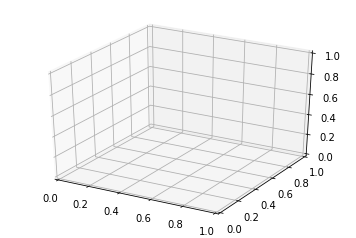

In [119]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.winter, linewidth=0, antialiased=True)
ax.set_zlim(0, 900000)

plt.show()

- MC 학습하는 함수로 하나로 합치기  (agent를 class로 관리하기)

- 3D plot 그리는 방법 다시 찾아보기

- TD 구현하기

- function approximation 구현하기
